In [1]:
!pip install git+https://github.com/deepmind/dm-haiku &> /dev/null
!pip install optax &> /dev/null
!git clone https://github.com/tsubakinoniwa/CSC2541-Project.git proj &> /dev/null

In [4]:
import haiku as hk
import optax
import tensorflow_datasets as tfds
import jax
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from jax import jit, value_and_grad
from functools import partial
from proj.hf.optimizer import hf
from tqdm.notebook import trange
from IPython.display import Pretty, display
from proj.hf.utils import *

from jax.config import config
config.update("jax_enable_x64", True)

from google.colab import drive
drive.mount('/content/drive')

In [5]:
def get_datasets_64():
    ds_builder = tfds.image_classification.Cifar10()
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(
        ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(
        ds_builder.as_dataset(split='test', batch_size=-1))
    
    X_train = (np.float64(train_ds['image']) / 255)
    X_test = (np.float64(test_ds['image']) / 255)

    pixel_avg = np.average(X_train, axis=0)
    X_train = X_train - pixel_avg
    X_test = X_test - pixel_avg

    y_train = jax.nn.one_hot(train_ds['label'], num_classes=10)
    y_test = test_ds['label']

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = get_datasets_64()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete3W7HR1/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete3W7HR1/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [7]:
def forward(X, is_training):
    model = hk.nets.ResNet18(num_classes=10)
    return model(X, is_training=is_training)

clf = hk.transform_with_state(forward)

@partial(jit, static_argnames=('is_training',))
def loss(params, state, batch, labels, is_training=True, L2_REG=1e-2):
    logits, state = clf.apply(params, state, None, batch, is_training)
    res = np.average(optax.softmax_cross_entropy(logits, labels)) + \
        L2_REG * dot(params, params) / 2
    return np.average(optax.softmax_cross_entropy(logits, labels)), state

@partial(jit, static_argnames=('is_training',))
def dloss(params, state, batch, labels, is_training=True):
    return value_and_grad(loss, has_aux=True)(
        params, state, batch, labels, True)

@jit
def get_acc(params, state, batch, labels):
    return np.average(np.argmax(
        clf.apply(params, state, None, batch, False)[0], axis=-1) == labels)

opt = hf(clf, loss, dloss)

In [8]:
@jit
def random_vec(prng_key, v):
    tree_def = jax.tree_structure(v)
    keys = jax.random.split(prng_key, tree_def.num_leaves)
    keys = jax.tree_unflatten(tree_def, keys)
    return jax.tree_map(lambda k, x: jax.random.normal(k, x.shape), keys, v)

@jit
def graft(M_update, D_update):
    norms = jax.tree_map(lambda x: np.linalg.norm(x), M_update)
    return jax.tree_map(lambda a, x: normalize(x) * a, norms, D_update)

In [24]:
# Plots the expected dot product between SGD direction and random descent
# direction as training progresses.
def check_dot_product(
    opt, X_train, y_train, X_test, y_test, batch_size=1000, num_epochs=5, 
    num_exps=1_000, is_hf=False, **kwargs):

    N = len(X_train)
    num_batches = int(np.ceil(N / batch_size))
    
    prng_key = jax.random.PRNGKey(37528349823)
    prng_key, init_key = jax.random.split(prng_key)

    params, state = clf.init(
        init_key, X_train[:batch_size], is_training=True)
    opt_state = opt.init(params, **kwargs)

    results = onp.zeros((num_epochs, num_exps, 62))

    for rep in trange(num_epochs):
        epoch_loss = 0

        prng_key, rep_key = jax.random.split(prng_key)
        inds = jax.random.permutation(rep_key, N)
        X_train, y_train = X_train[inds], y_train[inds]

        for batch in range(num_batches):
            batch_start = batch * batch_size
            batch_end = min((batch+1) * batch_size, N)

            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]
            
            (batch_loss, new_state), batch_grad = dloss(
                params, state, X_batch, y_batch, True)
            
            if is_hf:
                updates, opt_state = opt.update(
                    batch_grad, opt_state, params, state, X_batch, y_batch)
            else:
                updates, opt_state = opt.update(
                    batch_grad, opt_state, params)
            
            params = optax.apply_updates(params, updates)
            state = new_state
            
        for exp in trange(num_exps, leave=False):
            # Compute descent direction
            prng_key, dir_key = jax.random.split(prng_key)
            dir = random_vec(dir_key, params)
            
            prod = dot(dir, batch_grad)
            if prod > 0:
                dir = scale_vec(-1.0, dir)
                prod *= -1
            
            angles = onp.array(jax.tree_flatten(jax.tree_map(
                lambda a, b: np.vdot(a, b) / np.sqrt(
                    np.vdot(a, a) * np.vdot(b, b)),
                dir, batch_grad))[0])
            
            results[rep][exp] = angles

    
    return results

In [25]:
results = check_dot_product(
    optax.sgd(1e-2, 0.9), X_train, y_train, X_test, y_test, 
    batch_size=1000, num_epochs=5, num_exps=1_000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

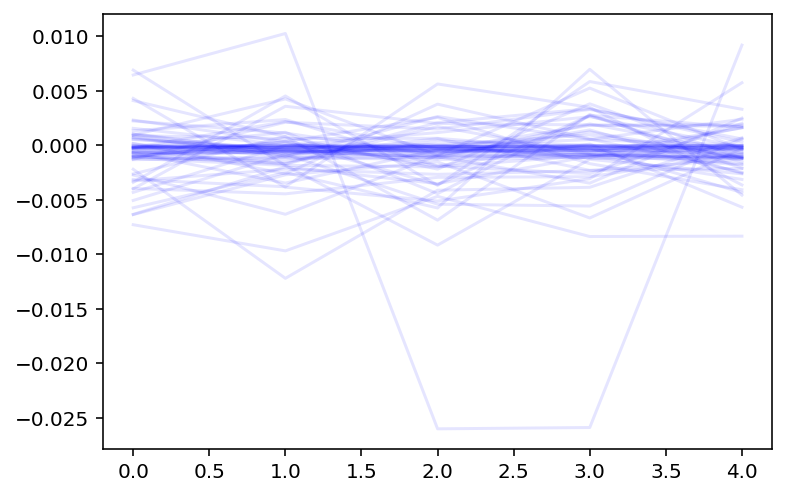

In [31]:
plt.plot(np.average(results, axis=1), c='b', alpha=0.1);

In [10]:
def random_descent_direction(
    opt, X_train, y_train, X_test, y_test, batch_size=1000, num_epochs=20, 
    is_hf=False, **kwargs):

    N = len(X_train)
    num_batches = int(np.ceil(N / batch_size))
    
    prng_key = jax.random.PRNGKey(37528349823)
    prng_key, init_key = jax.random.split(prng_key)

    params, state = clf.init(
        init_key, X_train[:batch_size], is_training=True)
    opt_state = opt.init(params, **kwargs)

    train_loss_hist = []
    val_acc_hist = []

    for rep in trange(num_epochs):
        epoch_loss = 0

        prng_key, rep_key = jax.random.split(prng_key)
        inds = jax.random.permutation(rep_key, N)
        X_train, y_train = X_train[inds], y_train[inds]

        for batch in range(num_batches):
            batch_start = batch * batch_size
            batch_end = min((batch+1) * batch_size, N)

            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]
            
            (batch_loss, new_state), batch_grad = dloss(
                params, state, X_batch, y_batch, True)
            
            if is_hf:
                updates, opt_state = opt.update(
                    batch_grad, opt_state, params, state, X_batch, y_batch)
            else:
                updates, opt_state = opt.update(
                    batch_grad, opt_state, params)
            
            # Compute descent direction
            prng_key, dir_key = jax.random.split(prng_key)
            dir = random_vec(dir_key, params)
            if dot(dir, batch_grad) > 0:
                dir = scale_vec(-1.0, dir)
            updates = graft(updates, dir)

            params = optax.apply_updates(params, updates)
            state = new_state
            
            epoch_loss += batch_loss

        epoch_loss /= num_batches
        train_loss_hist.append(epoch_loss)
        val_acc_hist.append(get_acc(params, state, X_test, y_test))
    
    return train_loss_hist, val_acc_hist

In [15]:
train_loss_hist, val_acc_hist = random_descent_direction(
    optax.sgd(2e-3, 0.9), X_train, y_train, X_test, y_test, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

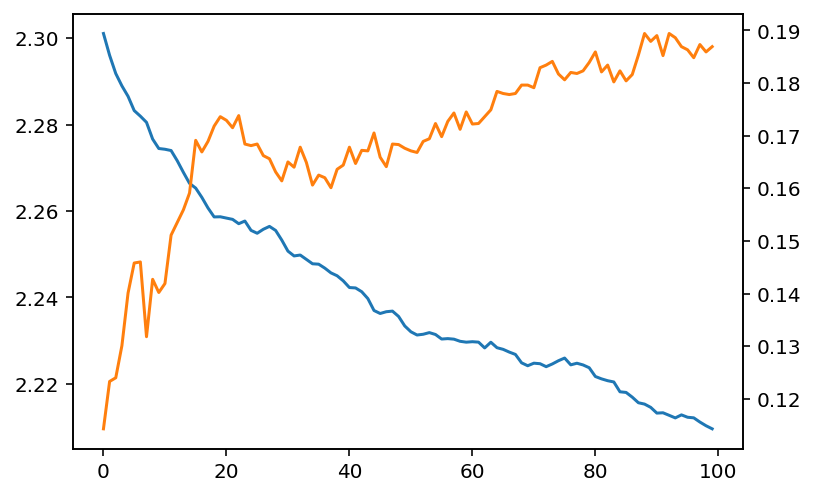

In [20]:
plt.plot(train_loss_hist)
plt.twinx()
plt.plot(val_acc_hist, 'tab:orange')

In [21]:
# Save the data
train_loss_hist_save, val_acc_hist_save = \
    np.array(train_loss_hist), np.array(val_acc_hist)

In [17]:
def run_single_optimizer(
    opt, X_train, y_train, X_test, y_test, batch_size=1000, num_epochs=20,
    is_hf=False, **kwargs):

    N = len(X_train)
    num_batches = int(np.ceil(N / batch_size))
    
    prng_key = jax.random.PRNGKey(37528349823)
    init_key, shuffle_key = jax.random.split(prng_key)

    params, state = clf.init(
        init_key, X_train[:batch_size], is_training=True)
    opt_state = opt.init(params, **kwargs)

    train_loss_hist = []
    val_acc_hist = []

    for rep in trange(num_epochs):
        epoch_loss = 0

        shuffle_key, rep_key = jax.random.split(shuffle_key)
        inds = jax.random.permutation(rep_key, N)
        X_train, y_train = X_train[inds], y_train[inds]

        for batch in trange(num_batches, leave=False):
            batch_start = batch * batch_size
            batch_end = min((batch+1) * batch_size, N)

            X_batch = X_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]
            
            (batch_loss, new_state), batch_grad = dloss(
                params, state, X_batch, y_batch, True)
            
            if is_hf:
                updates, opt_state = opt.update(
                    batch_grad, opt_state, params, state, X_batch, y_batch)
            else:
                updates, opt_state = opt.update(
                    batch_grad, opt_state, params)
            
            params = optax.apply_updates(params, updates)
            state = new_state
            
            epoch_loss += batch_loss

        epoch_loss /= num_batches
        train_loss_hist.append(epoch_loss)
        val_acc_hist.append(get_acc(params, state, X_test, y_test))
    
    return train_loss_hist, val_acc_hist

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

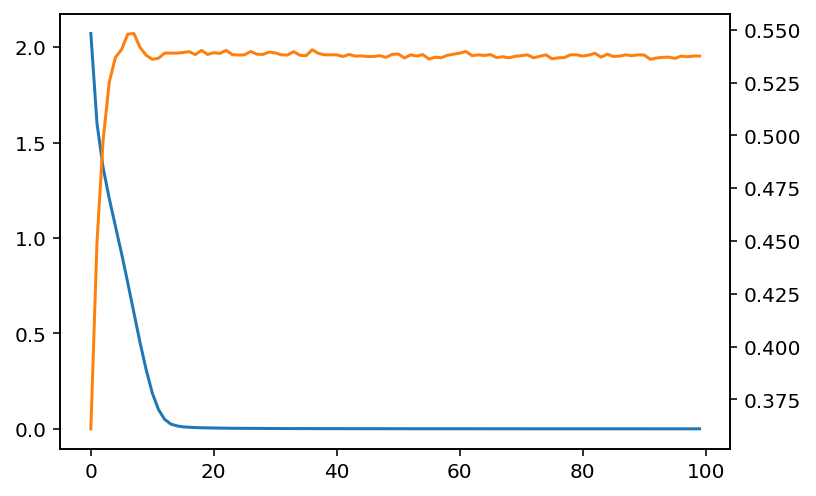

In [22]:
train_loss_hist, val_acc_hist = run_single_optimizer(
    optax.sgd(2e-3, 0.9), X_train, y_train, X_test, y_test,
    is_hf=False, num_epochs=100)
fig, ax = plt.subplots(1, 1)
ax.plot(train_loss_hist, 'tab:blue')
ax = ax.twinx()
ax.plot(val_acc_hist, 'tab:orange')

In [23]:
plt.rcParams["text.usetex"] = True
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{times}')
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended &> /dev/null0

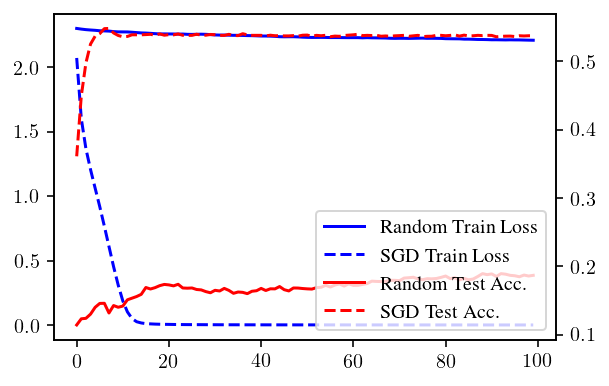

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6*0.75, 4*0.75))
line1, = ax.plot(train_loss_hist_save, 'b', label='Random Train Loss')
line2, = ax.plot(train_loss_hist, 'b--', label='SGD Train Loss')
# ax.set_ylabel('Training Loss')
# ax.set_yscale('log')
ax = ax.twinx()
line3, = ax.plot(val_acc_hist_save, 'r', label='Random Test Acc.')
line4, = ax.plot(val_acc_hist, 'r--', label='SGD Test Acc.')
# ax.set_ylabel('Test Accuracy')
ax.legend(handles=[line1, line2, line3, line4], loc='lower right', ncol=1)
fig.savefig('random_descent.pdf', bbox_inches='tight')
plt.show()